In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from ipdb import set_trace as bp
from numba.typed import List

from collections import namedtuple
import torch

np.set_printoptions(linewidth=160, precision=2)

In [2]:
ParamTuple = namedtuple("ParamTuple", ["gamma", "p"])

In [3]:
# @jit(nopython=True)
def value_iteration_with_policy(
    R: np.ndarray,
    T_agent: np.ndarray,
    gamma: float,
    tol: float = 1e-6,
):
    n_states = R.shape[0]
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=np.int32)
    while True:
        V_new = np.zeros(n_states)
        for s in range(n_states):
            action_values = R[s] + gamma * np.sum(T_agent[s] * V, axis=1)
            best_action = np.argmax(action_values)
            V_new[s] = action_values[best_action]
            policy[s] = best_action
        if np.max(np.abs(V - V_new)) < tol:
            break
        V = V_new
    V = V / np.max(V) * R.max()
    return V, policy

In [4]:
def soft_q_iteration(
    R: np.ndarray,  # R is a one-dimensional array with shape (n_states,)
    T_agent: np.ndarray,
    gamma: float,
    beta: float,  # Inverse temperature parameter for the softmax function
    tol: float = 1e-6,
) -> np.ndarray:
    n_states, n_actions, _ = T_agent.shape
    V = np.zeros(n_states)
    Q = np.zeros((n_states, n_actions))
    policy = np.zeros((n_states, n_actions))

    while True:
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate the Q-value for action a in state s
                Q[s, a] = R[s] + gamma * np.dot(T_agent[s, a], V)

        # Apply softmax to get a probabilistic policy
        max_Q = np.max(Q, axis=1, keepdims=True)
        exp_Q = np.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability
        policy = exp_Q / np.sum(exp_Q, axis=1, keepdims=True)

        # Calculate the value function V using the probabilistic policy
        V_new = np.sum(policy * Q, axis=1)

        # Check for convergence
        if np.max(np.abs(V - V_new)) < tol:
            break

        V = V_new

    return policy

In [5]:
# def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
#     trajectory = []
#     current_state = start_state
#     n_states = len(policy)

#     while len(trajectory) < max_steps:
#         if current_state in absorbing_states:
#             trajectory.append((current_state, -1, -1))  # Append the absorbing state
#             break
#         chosen_action = policy[current_state]
#         # Manually sample next_state based on T_true
#         cumulative_prob = 0.0
#         rand_num = np.random.rand()
#         next_state = 0
#         for s in range(n_states):
#             cumulative_prob += T_true[current_state, chosen_action, s]
#             if rand_num < cumulative_prob:
#                 next_state = s
#                 break

#         trajectory.append((current_state, chosen_action, next_state))
#         current_state = next_state

#     trajectory = np.array(trajectory)
#     return trajectory

In [6]:
def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
    trajectory = []
    current_state = start_state
    n_states, n_actions = policy.shape

    while len(trajectory) < max_steps:
        if current_state in absorbing_states:
            trajectory.append((current_state, -1, -1))  # Append the absorbing state
            break
        # Sample an action based on the policy probabilities for the current state
        action_probabilities = policy[current_state]
        chosen_action = np.random.choice(n_actions, p=action_probabilities)

        # Manually sample next_state based on T_true
        next_state = np.random.choice(n_states, p=T_true[current_state, chosen_action])

        trajectory.append((current_state, chosen_action, next_state))
        current_state = next_state

    return np.array(trajectory)

In [7]:
def generate_n_trajectories(
    T_true, policy, absorbing_states, n_trajectories=100, max_steps=100
):
    trajectories = list()
    for _ in range(n_trajectories):
        trajectories.append(
            generate_trajectory(T_true, policy, absorbing_states, max_steps=max_steps)
        )
    return trajectories

In [8]:
# @jit(nopython=True)
def make_absorbing(R: np.ndarray, T: np.ndarray) -> None:
    # Now all states with non-zero rewards are absorbing states
    reward_indices = np.where(R != 0)[0]
    T[reward_indices, :, :] = 0
    T[reward_indices, :, reward_indices] = 1

In [9]:
def transition_matrix(N, M, p, R=None):
    n_states = N * M
    n_actions = 4  # N, E, S, W

    # Initialize the transition matrix T(s, a, s')
    T = np.zeros((n_states, n_actions, n_states))

    # Helper function to convert 2D grid indices to 1D state index
    to_s = lambda i, j: i * M + j

    # Populate the transition matrix
    for i in range(N):
        for j in range(M):
            s = to_s(i, j)

            # Neighboring states
            neighbors = {
                "N": to_s(i - 1, j) if i > 0 else s,
                "E": to_s(i, j + 1) if j < M - 1 else s,
                "S": to_s(i + 1, j) if i < N - 1 else s,
                "W": to_s(i, j - 1) if j > 0 else s,
            }

            # Set transition probabilities
            for a, action in enumerate(["N", "E", "S", "W"]):
                T[s, a, neighbors[action]] = p
                for other_action in set(["N", "E", "S", "W"]) - {action}:
                    T[s, a, neighbors[other_action]] += (1 - p) / 3

    # Make the transition matrix absorbing
    if R is not None:
        make_absorbing(R, T)

    return T

In [91]:
def plot_trajectories(N, M, trajectories, reward_matrix, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(M, N))

    # Plot rewards as heatmap
    im = ax.imshow(
        reward_matrix.reshape(N, M), cmap="viridis", origin="upper", vmin=-10
    )

    # Plot trajectories
    for traj in trajectories:
        x_coords, y_coords = [], []
        for s, _, _ in traj:
            x, y = divmod(s, M)
            x_coords.append(x)
            y_coords.append(y)

        # Plot the trajectories with a color that stands out
        ax.plot(y_coords, x_coords, marker="o", color="white", alpha=0.5)

    # Assuming 'ax' is the Axes object and 'im' is the image or collection you want the colorbar for:
    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.set_label("Reward")

    # Restrict the colorbar values

    # To move the x-axis ticks to the top using the Axes object:
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")  # To also move the x-axis label if you have one

In [47]:
def plot_value_and_policy(
    value_function, policy, grid_shape, absorbing_states, title="", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=grid_shape[::-1])

    ax.imshow(
        value_function.reshape(grid_shape),
        cmap="viridis",
        origin="upper",
        interpolation="nearest",
    )
    # Make colorbar
    cbar = ax.figure.colorbar(ax.get_images()[0])

    for s, val in enumerate(value_function):
        if s in absorbing_states:
            continue  # Skip arrows for absorbing states

        row, col = divmod(s, grid_shape[1])
        action = policy[s]
        if action == 0:  # N
            dx, dy = 0, -0.4
        elif action == 1:  # E
            dx, dy = 0.4, 0
        elif action == 2:  # S
            dx, dy = 0, 0.4
        elif action == 3:  # W
            dx, dy = -0.4, 0
        # make arrow
        ax.arrow(col, row, dx, dy, head_width=0.1, head_length=0.1, fc="r", ec="r")

    ax.set_title(title)

In [48]:
# Make function that counts state visit frequencies from trajectories
@jit(nopython=True)
def count_state_visits(trajectories, n_states):
    state_visits = np.zeros(n_states)
    for traj in trajectories:
        for s, _, _ in traj:
            state_visits[s] += 1
    return state_visits / state_visits.sum()

### Define a world where different $\gamma$ leads to different optimal policies


In [49]:
# World definition

# Key: S: start, Number: Reward size

# Idea: Make a reaaaaaaaaally simple BigSmall world to see if the
# likelihood calculation we have give reasonable numbers

#   0 1 2
# 0 S . .
# 1 . . .
# 2 1 . 4

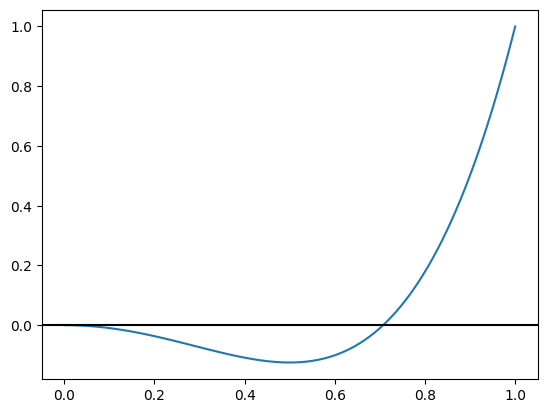

In [53]:
short_len = 2
long_len = 4
small_reward = 1

# Set big_reward such that the crossover for \gamma is at 0.75 (p = 1 for now)
big_reward = 2

xs = np.linspace(0, 1, 100)

plt.plot(xs, big_reward * xs**long_len - small_reward * xs**short_len)
plt.axhline(0, color="k")

In [54]:
N, M = 3, 3  # dimensions of the gridworld

n_states, n_actions = N * M, 4
R = np.array(
    [
        [0] * M,
        [0] * M,
        [small_reward, 0, big_reward],
    ]
).flatten()

true_params = ParamTuple(gamma=0.5, p=0.9)

T_agent_ground = transition_matrix(N, M, p=true_params.p)  # Agent's transition matrix
T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
absorbing_states = np.where(R > 0)[0]  # Absorbing states

make_absorbing(R, T_agent_ground)
make_absorbing(R, T_true)

In [55]:
# Generate V and policy
V_ground, ground_policy = value_iteration_with_policy(
    R, T_agent_ground, gamma=true_params.gamma
)
non_absorbing_states = np.where(R <= 0)[0]
ground_policy[non_absorbing_states]

array([2, 2, 2, 2, 2, 2, 1], dtype=int32)

In [56]:
def det_to_prob_pol(policy, smoothing=0.0):
    policy = np.eye(n_actions)[policy]
    policy += smoothing
    policy /= policy.sum(axis=1, keepdims=True)
    return policy

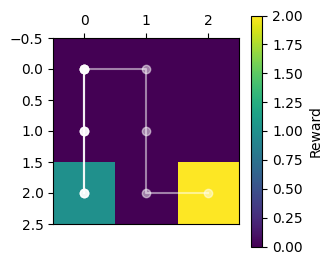

In [57]:
# Generate trajectories
trajectories = generate_n_trajectories(
    T_true,
    det_to_prob_pol(ground_policy),
    absorbing_states,
    n_trajectories=5,
    max_steps=100,
)

plot_trajectories(N, M, trajectories, R)

In [58]:
len(trajectories)

5

## Make the simplest possible case

We have two parameter samples from the posterior: $\{\gamma_1=0.5, \gamma_2 = 0.9\}$.

The first will produce a trajectory going down, the second will produce a trajectory going right.

Then, we can get the likelihood for each of these trajectories under their own $\gamma$.

Then, we can find one policy that tries to maximize the likelihood of the dataset $\mathcal D$ consisting of these two trajectories.

Hopefully (_dear god_) this will be smaller than the likelihood of the dataset $\mathcal D$ under the true $\gamma$-s.


In [59]:
posterior1 = 0.5
posterior2 = 0.9

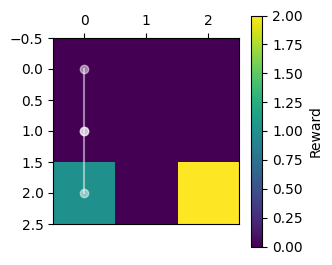

In [60]:
# Make trajectory for posterior1
_, policy1 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior1)
policy1 = det_to_prob_pol(policy1, smoothing=0.0)

# Generate trajectories
trajectories1 = generate_n_trajectories(
    T_true, policy1, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, trajectories1, R)

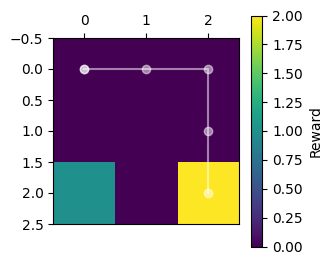

In [61]:
# Make trajectory for posterior2
_, policy2 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior2)
policy2 = det_to_prob_pol(policy2, smoothing=0.0)

# Generate trajectories
trajectories2 = generate_n_trajectories(
    T_true, policy2, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, trajectories2, R)

[[5.84e-06 8.14e-01 1.86e-01 5.84e-06]
 [7.85e-07 5.59e-01 4.41e-01 5.63e-12]
 [1.70e-07 1.70e-07 1.00e+00 2.38e-13]
 [1.28e-11 1.00e+00 7.83e-20 4.08e-07]
 [1.90e-13 7.97e-01 2.03e-01 4.34e-14]
 [2.16e-15 1.27e-08 1.00e+00 1.70e-15]
 [2.50e-01 2.50e-01 2.50e-01 2.50e-01]
 [1.70e-15 1.00e+00 3.24e-09 1.33e-34]
 [2.50e-01 2.50e-01 2.50e-01 2.50e-01]]


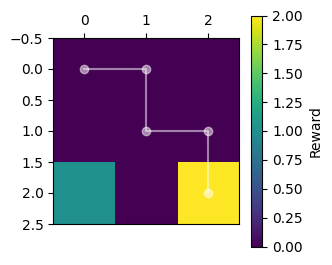

In [62]:
# Make a trajectory with soft Q-iteration
soft_policy = soft_q_iteration(R, T_agent_ground, gamma=posterior2, beta=10.0)
print(soft_policy)

# Generate trajectories
soft_trajectories = generate_n_trajectories(
    T_true, soft_policy, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, soft_trajectories, R)

<BarContainer object of 4 artists>

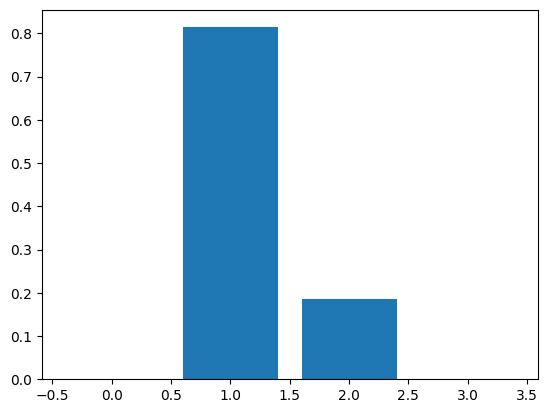

In [63]:
# Plot distribution of Q-values for state 0
plt.bar(np.arange(soft_policy[0].shape[0]), soft_policy[0])

In [64]:
# Make function to calculate log-likelihood of a trajectory given a transition matrix and policy
def log_likelihood(T, policy, trajectory):
    log_likelihood = 0.0
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += np.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood


def log_likelihood_torch(T, policy, trajectory):
    log_likelihood = torch.tensor(0.0)
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += torch.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood

## Put it all together to a more comprehensive example


In [65]:
from tqdm import trange


def random_policy_maximization(n_states, n_actions, trajectories, T_true):
    best_likelihood = -np.inf
    best_pol = None
    best_list = []
    for i in trange(1_000_000):
        # Sample a new policy
        cand_pol = np.random.dirichlet(np.ones(n_actions), size=n_states)

        mean_log_likelihood = np.array(
            [log_likelihood(T_true, cand_pol, traj) for traj in trajectories]
        ).mean()

        if mean_log_likelihood > best_likelihood:
            best_likelihood = mean_log_likelihood
            best_pol = cand_pol
            best_list.append((i, best_likelihood))

    print(f"Best policy: {best_pol}")

    # Plot the best_likelihood list with circles
    # plt.plot([x[0] for x in best_list], [x[1] for x in best_list], "-o", alpha=0.5)

    print(f"Best likelihood: {best_likelihood}")

    return best_pol, best_likelihood

In [66]:
def grad_policy_maximization(n_states, n_actions, trajectories, T_true, n_iter=1_000):
    q_function = torch.ones(n_states, n_actions) / n_actions
    q_function.requires_grad = True
    optimizer = torch.optim.Adam([q_function], lr=0.1)
    T_true = torch.tensor(T_true)

    for _ in range(n_iter):
        optimizer.zero_grad()
        candidate_pi = torch.softmax(q_function, dim=1)
        mean_log_likelihood = torch.stack(
            [log_likelihood_torch(T_true, candidate_pi, traj) for traj in trajectories]
        ).mean()
        (-mean_log_likelihood).backward()
        optimizer.step()

    candidate_pi = torch.softmax(q_function.detach(), dim=1)

    return candidate_pi

In [67]:
import random


def run_likelihood_exp(small_reward=1, big_reward=4, N=3, M=3, seed=69):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    n_states, n_actions = N * M, 4
    R = np.zeros((N, M))

    R[-1, 0] = small_reward
    R[-1, -1] = big_reward

    R = R.flatten()

    T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
    T_agent_ground = transition_matrix(N, M, p=0.9)
    absorbing_states = np.where(R > 0)[0]  # Absorbing states
    make_absorbing(R, T_true)
    make_absorbing(R, T_agent_ground)

    posteriors = np.linspace(0.5, 0.9, 2)
    # policies = []
    all_trajectories = []
    star_likelihoods = []

    # Make trajectory for posteriors
    for posterior in posteriors:
        policy = soft_q_iteration(R, T_agent_ground, gamma=posterior, beta=100.0)
        # _, policy = value_iteration_with_policy(R, T_agent_ground, gamma=posterior)
        # policy = det_to_prob_pol(policy, smoothing=0.0)

        # Generate trajectories
        trajectories = generate_n_trajectories(
            T_true, policy, absorbing_states, n_trajectories=5, max_steps=100
        )

        all_trajectories += trajectories
        # Calculate likelihood of trajectories
        star_likelihoods += [
            log_likelihood(T_true, policy, traj) for traj in trajectories
        ]

    plot_trajectories(N, M, all_trajectories, R)

    max_likelihood_policy = grad_policy_maximization(
        n_states,
        n_actions,
        all_trajectories,
        T_true,
    )

    # Now use the max_likelihood_policy to calculate the likelihood of each of the trajectories so we can normalize with the star likelihoods
    likelihoods = [
        log_likelihood(T_true, max_likelihood_policy, traj) for traj in all_trajectories
    ]

    likelihood_array = np.array([star_likelihoods, likelihoods]).T

    return likelihood_array

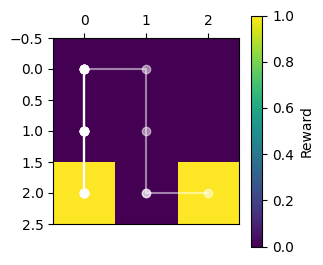

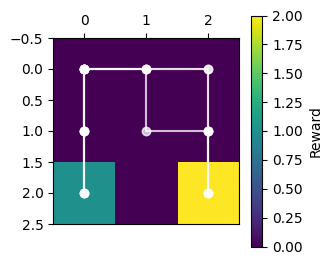

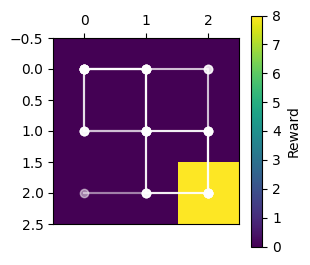

In [68]:
results1 = (
    run_likelihood_exp(big_reward=1),
    run_likelihood_exp(big_reward=2),
    run_likelihood_exp(small_reward=0, big_reward=8),
)

In [69]:
res1 = np.array(results1)

# res1 = np.exp(res1)
# res1 /= res1[:, 0:1]
res1 = res1.mean(axis=1)
res1 = -np.diff(res1, axis=1).flatten()

with np.printoptions(precision=5, suppress=True):
    print(res1)

[-0.13887  0.69047 -0.24026]


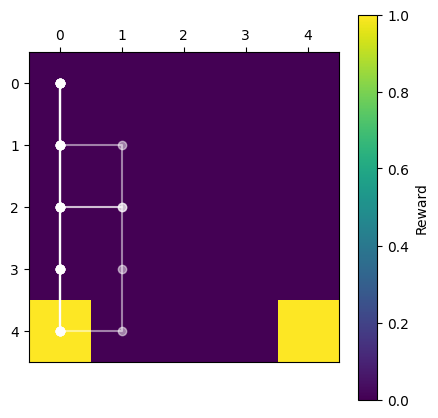

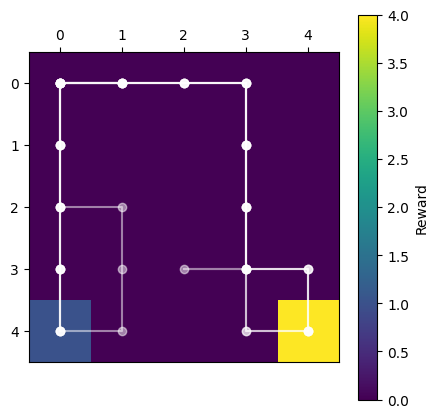

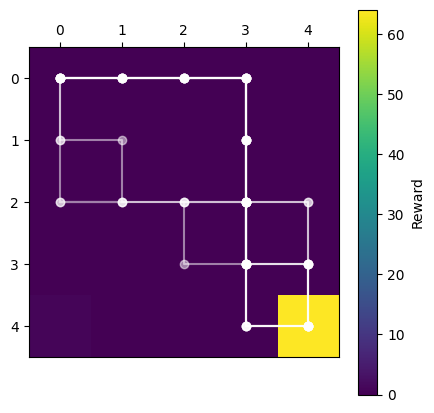

In [70]:
results2 = (
    run_likelihood_exp(big_reward=1, N=5, M=5),
    run_likelihood_exp(big_reward=4, N=5, M=5),
    run_likelihood_exp(big_reward=64, N=5, M=5),
)

In [71]:
res2 = np.array(results2)

res2 = np.exp(res2)
# res2 /= res2[:, :, :1]
res2 = res2[:, :, :].mean(axis=1)
res2 = -np.diff(res2, axis=1).flatten()

with np.printoptions(precision=10, suppress=True):
    print(res2)

[-0.0046673519  0.1340630483  0.0246116693]


## Experiment with inserting walls


In [72]:
def insert_walls_into_transition_matrix(T, n_walls, start_state=0):
    """
    Randomly inserts wall blocks into the transition matrix T.

    :param T: The transition matrix with shape (n_states, n_actions, n_states).
    :param n_walls: The number of walls (cells with zero transition probability) to insert.
    :return: The modified transition matrix with walls inserted.
    """
    n_states, n_actions, _ = T.shape
    T = T.copy()

    # Enumerate all states that can have a wall (i.e. states with reward = 0 and not the start state)
    wall_candidates = np.where((R <= 0) & (np.arange(n_states) != start_state))[0]

    # Ensure we're not inserting more walls than there are states.
    n_walls = min(n_walls, len(wall_candidates))

    # Randomly select states to turn into walls.
    wall_states = np.random.choice(wall_candidates, size=n_walls, replace=False)

    # Set the transition probabilities into the wall states to zero.
    for s in wall_states:
        for a in range(n_actions):
            # Zero out all transitions leading into the wall state.
            T[:, a, s] = 0

    # After modifying the transition probabilities, we need to re-normalize the transition
    # probabilities for each state and action to ensure they still sum to 1.
    for s in range(n_states):
        for a in range(n_actions):
            prob_sum = T[s, a].sum()
            if prob_sum > 0:
                T[s, a] /= prob_sum

    return T, wall_states

In [87]:
from matplotlib.patches import Rectangle


def plot_environment(reward_function, wall_states, start_state=(0, 0), ax=None):
    # Assume the reward function is already reshaped to a 2D grid
    N, M = reward_function.shape
    # Identify wall states is the indixes into the

    wall_states = set([(s // M, s % M) for s in wall_states])

    if ax is None:
        fig, ax = plt.subplots()
    ax.matshow(reward_function, cmap=plt.cm.Wistia)

    # Annotate each cell with the reward, start, and wall
    for (i, j), val in np.ndenumerate(reward_function):
        if (i, j) == start_state:
            ax.text(j, i, "Start", va="center", ha="center")
        elif (i, j) in wall_states:
            # Add a dark gray rectangle to represent the wall
            ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, color="darkgray"))
        else:
            ax.text(j, i, f"{val:.2f}", va="center", ha="center")

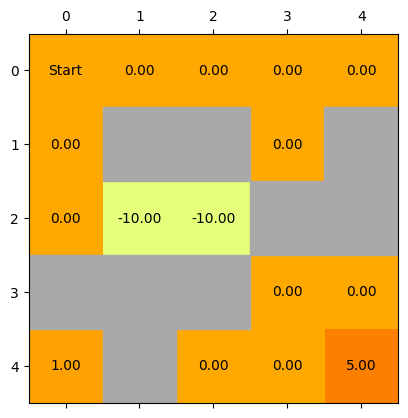

In [81]:
N, M = 5, 5

n_states, n_actions = N * M, 4
R = np.zeros((N, M))

R[-1, 0] = 1
R[-1, -1] = 5

# Add deadly states
R[2, 1] = -10
R[2, 2] = -10

R = R.flatten()

T_true = transition_matrix(N, M, p=0.9)  # True transition matrix

# Sample random number of walls to insert
n_walls = np.random.randint(0, n_states // 2)

T_candidate, wall_states = insert_walls_into_transition_matrix(T_true, n_walls=n_walls)

plot_environment(R.reshape(N, M), wall_states)

## Put it all together into one big function

The procedure is as follows:

1. Initialize variables for storing the highest Bayesian regret and the corresponding environment $T$.
1. Sample $n$ samples of the parameters $\theta=(\gamma_i, p_i)$ from the posterior $p(\theta|\mathcal D)$ (But we start with a uniform prior).
1. Create $t = |T|$ randomly generated "worlds", each with a different layout of walls.
1. For each world
   1. For each of the $n$ parameter samples
      1. Find the optimal policy $\pi^*$ for each of the $n$ parameter samples.
      1. For each of the $n$ policies, create $m$ trajectories $\tau$.
      1. For each of the $n$ policies, calculate the likelihood of the trajectories $\tau_i$ under the policy $\pi_i^*$. I.e., calculate the likelihood of the trajectories $\tau_i$ under the parameters $\theta_i$.
      1. Put all of these trajectories together into a set of all the trajectories $\tau$
   1. Find one policy $\pi$ that maximizes the likelihood of the trajectories $\tau$ with gradient ascent.
   1. Calculate the Bayesian regret of the policy $\pi$ as the difference between the mean of the likelihood of the trajectories $\tau$ under the true parameters $\theta^*$ and the mean of the likelihood of the trajectories $\tau$ under the policy $\pi$.
   1. If the Bayesian regret is higher than the highest Bayesian regret so far, store the Bayesian regret and the corresponding environment $T$.
1. Return the highest Bayesian regret and the corresponding environment $T$.


In [40]:
# This function is a standin for the BIRL procedure that will create a proper posterior sampling
def get_parameter_sample(n_samples):
    n_sqrt = int(np.sqrt(n_samples))
    ps = np.linspace(0.01, 0.99, n_sqrt)
    gammas = np.linspace(0.01, 0.99, n_sqrt)

    return list(product(ps, gammas))

In [41]:
class Environment:
    def __init__(self, N, M, R, T_true, wall_states):
        self.N = N
        self.M = M
        self.R = R
        self.T_true = T_true
        self.wall_states = wall_states

In [42]:
from collections import deque


def is_terminal_reachable(T, goal_states):
    """
    Check if any of the terminal states are reachable from the top-left state (0, 0)
    using breadth-first search (BFS).

    :param T: The transition matrix with shape (n_states, n_actions, n_states)
    :param terminal_states: A list of terminal states
    :return: True if any terminal state is reachable, False otherwise
    """
    n_states, n_actions, _ = T.shape
    visited = [False] * n_states  # Keep track of visited states
    queue = deque([0])  # Start BFS from the top-left state (index 0)
    visited[0] = True

    while queue:
        current_state = queue.popleft()

        # If the current state is a terminal state, return True
        if current_state in goal_states:
            return True

        # Add all reachable states from the current state to the queue
        for a in range(n_actions):
            for s_next in range(n_states):
                if T[current_state, a, s_next] > 0 and not visited[s_next]:
                    visited[s_next] = True
                    queue.append(s_next)

    # If BFS completes without finding a terminal state, return False
    return False

In [82]:
def get_candidate_environments(n_envs, N, M, T_true, R) -> list[Environment]:
    envs = []
    goal_states = np.where(R > 0)[0]

    pbar = tqdm(desc="Generating candidate environments", total=n_envs)

    while len(envs) < n_envs:
        # Sample random number of walls to insert
        n_walls = np.random.randint(0, n_states // 2)

        T_candidate, wall_states = insert_walls_into_transition_matrix(
            T_true, n_walls=n_walls
        )

        # Check if the terminal state is reachable
        if not is_terminal_reachable(T_candidate, goal_states):
            continue

        envs.append(Environment(N, M, R, T_candidate, wall_states))
        pbar.update(1)

    return envs

In [86]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 10
n_posterior_samples = 10
n_traj_per_sample = 5

## 0.2 Setup the environment
N, M = 5, 5
n_states, n_actions = N * M, 4

# Create a type of BigSmall world with a dangerous zone
R = np.zeros((N, M))
R[-1, 0] = 1
R[-1, -1] = 4
R[2, 1] = -100
R[2, 2] = -100
R = R.flatten()

# Create the true transition matrix
T_true = transition_matrix(N, M, p=0.9, R=R)
absorbing_states = np.where(R != 0)[0]  # Absorbing states

# 1. Initialize storage
highest_regret = -np.inf
next_env = None

# 2. Sample $n$ parameter tuples from the prior
posterior_sample = get_parameter_sample(n_posterior_samples)

# 3. Generate $m$ different candidate environments
candidate_envs = get_candidate_environments(n_env_samples, N, M, T_true, R)
pbar = tqdm(
    candidate_envs,
    desc="Evaluating candidate environments",
    postfix={"highest_regret": highest_regret},
)

for candidate_env in pbar:
    policies = []
    trajectories = []
    likelihoods = []

    for p, gamma in posterior_sample:
        # 4.1.1 Find the optimal policy for this env and posterior sample
        T_agent = transition_matrix(N, M, p=p, R=R)
        policy = soft_q_iteration(R, T_agent, gamma=gamma, beta=100.0)
        policies.append(policy)

        # 4.1.2 Generate $m$ trajectories from this policy
        policy_traj = generate_n_trajectories(
            candidate_env.T_true,
            policy,
            absorbing_states,
            n_trajectories=n_traj_per_sample,
            max_steps=100,
        )

        # 4.1.3 Calculate the likelihood of the trajectories
        policy_likelihoods = [
            log_likelihood(candidate_env.T_true, policy, traj) for traj in policy_traj
        ]

        # 4.1.4 Store the trajectories and likelihoods
        trajectories += policy_traj
        likelihoods += policy_likelihoods

    # 4.2 Find the policy with the highest likelihood
    most_likely_policy = grad_policy_maximization(
        n_states,
        n_actions,
        trajectories,
        T_true,
        n_iter=100,
    )

    # 4.3 Calculate the regret of the most likely policy
    most_likely_likelihoods = [
        log_likelihood(T_true, most_likely_policy, traj) for traj in trajectories
    ]

    all_likelihoods = np.array([likelihoods, most_likely_likelihoods]).T
    all_likelihoods = np.exp(all_likelihoods)

    regret = -np.diff((all_likelihoods).mean(axis=0), axis=0)

    # 4.4 If the regret is higher than the highest regret so far, store the env and policy
    if regret > highest_regret:
        highest_regret = regret
        next_env = candidate_env
        pbar.set_postfix({"highest_regret": highest_regret})

    candidate_env.trajectories = trajectories

# 5. Return the env and policy with the highest regret
next_env, highest_regret

Evaluating candidate environments: 100%|██████████| 10/10 [00:38<00:00,  3.86s/it, highest_regret=[0.19]]


(<__main__.Environment at 0x17e803c50>, array([0.19]))

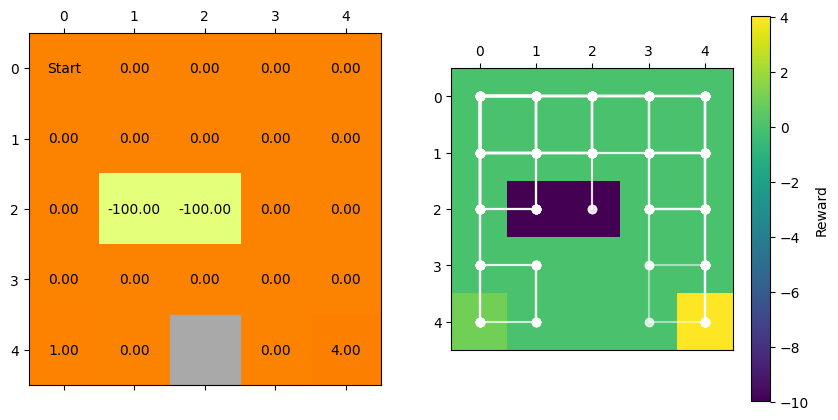

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Show the chosen environment
plot_environment(R.reshape(N, M), next_env.wall_states, ax=ax1)

# Show the trajectories
plot_trajectories(N, M, next_env.trajectories, R, ax=ax2)